In [26]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time
import warnings
from collections import deque
import psutil
import os
import warnings
warnings.filterwarnings('ignore')

In [27]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
FILE_PATH = "C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = 'C:\\workarea\\CNN model\\dataset\\radioml2018\\versions\\2\\classes-fixed.json' 

TARGET_MODULATIONS = ['OOK','4ASK','8ASK','BPSK', 'QPSK', 
                      '8PSK',
                      '16PSK', '16QAM',
                     '64QAM']
#TARGET_MODULATIONS = ['OOK','4ASK','BPSK', 'QPSK', '8PSK','16QAM','GMSK']
BATCH_SIZE = 1024 # adjust to my laptop 
#LEARNING_RATE = 0.003 
NUM_EPOCHS = 300 
NUM_WORKERS = 0 #Temporary check it  

INPUT_CHANNELS = 2 
SEQUENCE_LENGTH = 1024 
NUM_CLASSES = len(TARGET_MODULATIONS) # adjust this to 

patience = 25

print("📋 Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
#print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")

📋 Training Parameters:
  Batch size: 1024
  Epochs: 300


In [39]:
def dataset_split(data,
                  modulations_classes,
                  modulations,
                  snrs,
                  target_modulations,
                  mode,
                  target_snrs,
                  train_proportion=0.8, # training 70 %
                  valid_proportion=0.2, # validation 20 %
                  test_proportion=0.0, # testing 10 % 
                  seed=48):
    np.random.seed(seed)
    X_output = []
    Y_output = []
    Z_output = []                                   

    target_modulation_indices = [modulations_classes.index(modu) for modu in target_modulations]

    for modu in target_modulation_indices:
        for snr in target_snrs:
            snr_modu_indices = np.where((modulations == modu) & (snrs == snr))[0]

            np.random.shuffle(snr_modu_indices)
            num_samples = len(snr_modu_indices)
            train_end = int(train_proportion * num_samples)
            valid_end = int((train_proportion + valid_proportion) * num_samples)

            if mode == 'train':
                indices = snr_modu_indices[:train_end]
            elif mode == 'valid':
                indices = snr_modu_indices[train_end:valid_end]
            elif mode == 'test':
                indices = snr_modu_indices[valid_end:]
            else:
                raise ValueError(f'unknown mode: {mode}. Valid modes are train, valid and test')

            X_output.append(data[np.sort(indices)])
            Y_output.append(modulations[np.sort(indices)])
            Z_output.append(snrs[np.sort(indices)])

    X_array = np.vstack(X_output)
    Y_array = np.concatenate(Y_output)
    Z_array = np.concatenate(Z_output)
    for index, value in enumerate(np.unique(np.copy(Y_array))):
        Y_array[Y_array == value] = index
    return X_array, Y_array, Z_array

In [40]:
class RadioMLIQDataset(Dataset):
    """Dataset class for RadioML18 data formatted for CNNIQModel dual-branch architecture.
    
    Loads RadioML18 HDF5 data and returns separate I and Q tensors in 2D format
    suitable for CNNIQModel's separate branch processing.
    """
    
    def __init__(self, mode: str, use_fft: bool = False, seed: int = 48):
        """Initialize RadioMLIQDataset.
        
        Args:
            mode: Dataset split mode ('train', 'valid', or 'test').
            use_fft: Whether to apply FFT transformation to signals.
            seed: Random seed for dataset splitting.
            
        Raises:
            FileNotFoundError: If HDF5 or JSON files cannot be found.
            ValueError: If mode is not valid or data dimensions are incompatible.
        """
        super(RadioMLIQDataset, self).__init__()
        
        # Configuration (you'll need to define these constants)
        self.file_path = FILE_PATH 
        self.json_path = JSON_PATH 
        self.target_modulations = TARGET_MODULATIONS
        self.use_fft = use_fft
        self.mode = mode
        
        # Validate mode
        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"Mode must be 'train', 'valid', or 'test', got '{mode}'")
        
        # Load data files
        try:
            self.hdf5_file = h5py.File(self.file_path, 'r')
            self.modulation_classes = json.load(open(self.json_path, 'r'))
        except FileNotFoundError as e:
            raise FileNotFoundError(f"Error loading data files: {e}")
        except Exception as e:
            print(f"Error loading file: {e}")
            raise e
        
        # Load raw data
        self.X = self.hdf5_file['X']
        self.Y = np.argmax(self.hdf5_file['Y'], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]
        
       
        num_mods = len(self.target_modulations)   
        num_snrs = 26         
        
        train_proportion = (num_mods * num_snrs * nf_train) / self.X.shape[0]
        valid_proportion = (num_mods * num_snrs * nf_valid) / self.X.shape[0]
        test_proportion  = (num_mods * num_snrs * nf_test ) / self.X.shape[0]
        
        self.target_snrs = np.unique(self.Z)
        
        # Split dataset
        self.X_data, self.Y_data, self.Z_data = dataset_split(
            data=self.X,
            modulations_classes=self.modulation_classes,
            modulations=self.Y,
            snrs=self.Z,
            mode=mode,
            train_proportion=train_proportion,
            valid_proportion=valid_proportion,
            test_proportion=test_proportion,
            target_modulations=self.target_modulations,
            target_snrs=self.target_snrs,
            seed=seed
        )
        
        # Apply I/Q swap correction for AMC compatibility
        # print(f"🔧 Applying I/Q swap fix to {mode} dataset...")
        self.X_data = self.X_data[:, :, [0, 1]]
        # print(f"✅ I/Q channels corrected for real-world compatibility")
        
        # Validate signal length for 2D reshaping
        signal_length = self.X_data.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024 for 32x32 reshape, got {signal_length}")

        import math
        
        L = signal_length
        H = int(math.floor(math.sqrt(L)))
        while L % H != 0:
            H -= 1
        W = L // H
        
        self.H, self.W = H, W
        print(f"🔧 Signals will be reshaped to ({H}, {W}) for sequence length {L}")
        print(f"✅ Aspect ratio: {W/H:.2f}, Total elements preserved: {H*W} = {L}")
        
        if self.use_fft:
            print("Dataset configured to use FFT as input")
        
        # Store dataset statistics
        self.num_data = self.X_data.shape[0]
        self.num_lbl = len(self.target_modulations)
        self.num_snr = self.target_snrs.shape[0]
        
        print(f"RadioMLIQDataset {mode}: {self.num_data} samples, "
              f"{self.num_lbl} classes, {self.num_snr} SNR levels")
    
    def __len__(self) -> int:
        """Return the number of samples in the dataset.
        
        Returns:
            Number of samples.
        """
        return self.X_data.shape[0]
    

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= self.num_data:
            raise IndexError(f"Index {idx} out of range for dataset of size {self.num_data}")

        # Raw sample
        x_raw = self.X_data[idx]       # shape: (L, 2)
        y     = int(self.Y_data[idx])  # scalar label
        z     = float(self.Z_data[idx])

        # To tensor & transpose to (2, L)
        x = torch.from_numpy(x_raw).float().transpose(0, 1)

        # Optional FFT preprocessing
        if self.use_fft:
            complex_sig = torch.complex(x[0], x[1])
            fft_res     = torch.fft.fft(complex_sig)
            x_real = torch.real(fft_res)
            x_imag = torch.imag(fft_res)
            x = torch.stack([x_real, x_imag], dim=0)

        # Separate I/Q
        i_signal = x[0]  # (L,)
        q_signal = x[1]

        # Convert to amplitude & phase
        amplitude = torch.sqrt(i_signal**2 + q_signal**2)
        phase     = torch.atan2(q_signal, i_signal)

        # Dynamic reshape to 2D
        i_2d = amplitude.view(1, self.H, self.W)
        q_2d = phase.view(1, self.H, self.W)

        return i_2d, q_2d, y, z

    def get_signal_stats(self):
        """Compute basic stats over a sample of signals."""
        sample_indices = np.random.choice(self.num_data, min(1000, self.num_data), replace=False)
        i_vals, q_vals = [], []
        for idx in sample_indices:
            i2d, q2d, _, _ = self[idx]
            i_vals.append(i2d.flatten())
            q_vals.append(q2d.flatten())
        i_all = torch.cat(i_vals)
        q_all = torch.cat(q_vals)
        return {
            'i_mean': i_all.mean().item(),
            'i_std':  i_all.std().item(),
            'q_mean': q_all.mean().item(),
            'q_std':  q_all.std().item(),
            'shape':  (1, self.H, self.W),
            'num_samples': self.num_data
        }

    def close(self):
        if hasattr(self, 'hdf5_file'):
            self.hdf5_file.close()

    def __del__(self):
        self.close()

In [41]:
try:
    from CNN_LSTM_IQ import create_enhanced_CNNLSTMIQModel

    # Match the real signature: (n_labels, dropout_rate)
    model_CNNLSMTIQ = create_enhanced_CNNLSTMIQModel(n_labels=NUM_CLASSES, dropout_rate=0.3).to(device)
    print("✅ Successfully built CNNIQModel:", model_CNNLSMTIQ)

except Exception as e:
    print(f"⚠️ Could not build CNNIQModel: {e}")

✅ Successfully built CNNIQModel: CNNLSTMIQModel(
  (i_branch): CNNLSTMBranch(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (leaky_relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (dropout): Dropout2d(p=0.22499999999999998, inplace=False)
    (lstm1): LSTM(


Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 62712 samples, 9 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 62712 samples, 9 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 18018 samples, 9 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 62712
Train dataset size: 62712 (60%)
Validation dataset size: 18018 (40%)

Starting training...


Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.37it/s]
                                                            
Epochs:   0%|                                   | 1/300 [00:10<54:28, 10.93s/it]

Epoch 1/300: Train Loss: 1.4918 | Train Acc: 55.66% | Valid Loss: 1.5411 | Valid Acc: 51.15%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.33it/s]
                                                            
Epochs:   1%|▏                                  | 2/300 [00:21<54:06, 10.90s/it]

Epoch 2/300: Train Loss: 1.4490 | Train Acc: 58.36% | Valid Loss: 1.4648 | Valid Acc: 56.36%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.49it/s]
                                                            
Epochs:   1%|▎                                  | 3/300 [00:32<53:46, 10.86s/it]

Epoch 3/300: Train Loss: 1.4443 | Train Acc: 58.81% | Valid Loss: 1.4538 | Valid Acc: 57.35%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.35it/s]
                                                            
Epochs:   1%|▍                                  | 4/300 [00:43<53:46, 10.90s/it]

Epoch 4/300: Train Loss: 1.4423 | Train Acc: 58.73% | Valid Loss: 1.4485 | Valid Acc: 57.66%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.29it/s]
                                                            
Epochs:   2%|▌                                  | 5/300 [00:54<53:26, 10.87s/it]

Epoch 5/300: Train Loss: 1.4395 | Train Acc: 58.67% | Valid Loss: 1.4661 | Valid Acc: 56.79%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.48it/s]
                                                            
Epochs:   2%|▋                                  | 6/300 [01:05<53:00, 10.82s/it]

Epoch 6/300: Train Loss: 1.4398 | Train Acc: 58.88% | Valid Loss: 1.4622 | Valid Acc: 56.87%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.47it/s]
                                                            
Epochs:   2%|▊                                  | 7/300 [01:15<52:46, 10.81s/it]

Epoch 7/300: Train Loss: 1.4385 | Train Acc: 59.00% | Valid Loss: 1.5000 | Valid Acc: 55.80%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.42it/s]
                                                            
Epochs:   3%|▉                                  | 8/300 [01:26<52:31, 10.79s/it]

Epoch 8/300: Train Loss: 1.4359 | Train Acc: 58.95% | Valid Loss: 1.4620 | Valid Acc: 57.24%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.35it/s]
                                                            
Epochs:   3%|█                                  | 9/300 [01:37<52:28, 10.82s/it]

Epoch 9/300: Train Loss: 1.4315 | Train Acc: 59.29% | Valid Loss: 1.4648 | Valid Acc: 57.60%



Training:  89%|███████████▌ | 55/62 [00:08<00:01,  6.17it/s]
                                                            
Epochs:   3%|█▏                                | 10/300 [01:48<52:53, 10.94s/it]

Epoch 10/300: Train Loss: 1.4324 | Train Acc: 58.96% | Valid Loss: 1.4598 | Valid Acc: 56.90%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.26it/s]
                                                            
Epochs:   4%|█▏                                | 11/300 [01:59<52:51, 10.97s/it]

Epoch 11/300: Train Loss: 1.4349 | Train Acc: 59.10% | Valid Loss: 1.4486 | Valid Acc: 57.39%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.38it/s]
                                                            
Epochs:   4%|█▎                                | 12/300 [02:10<52:47, 11.00s/it]

Epoch 12/300: Train Loss: 1.4313 | Train Acc: 59.26% | Valid Loss: 1.4530 | Valid Acc: 56.99%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.46it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [02:21<52:13, 10.92s/it]

Epoch 13/300: Train Loss: 1.4302 | Train Acc: 59.39% | Valid Loss: 1.4504 | Valid Acc: 57.17%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.30it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [02:32<56:06, 11.73s/it]

Early stopping at epoch 14

Training complete.
Best validation accuracy: 57.66%


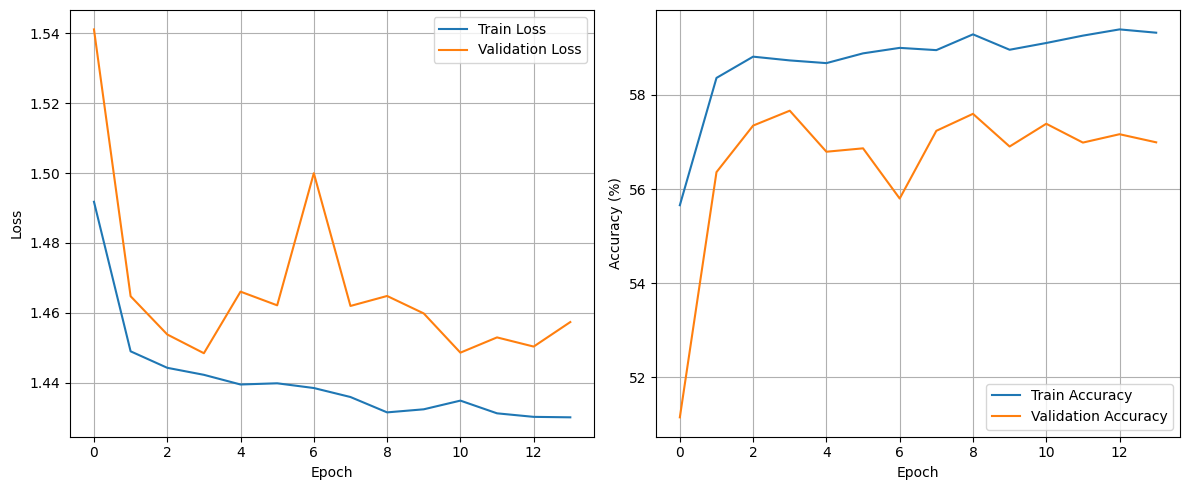

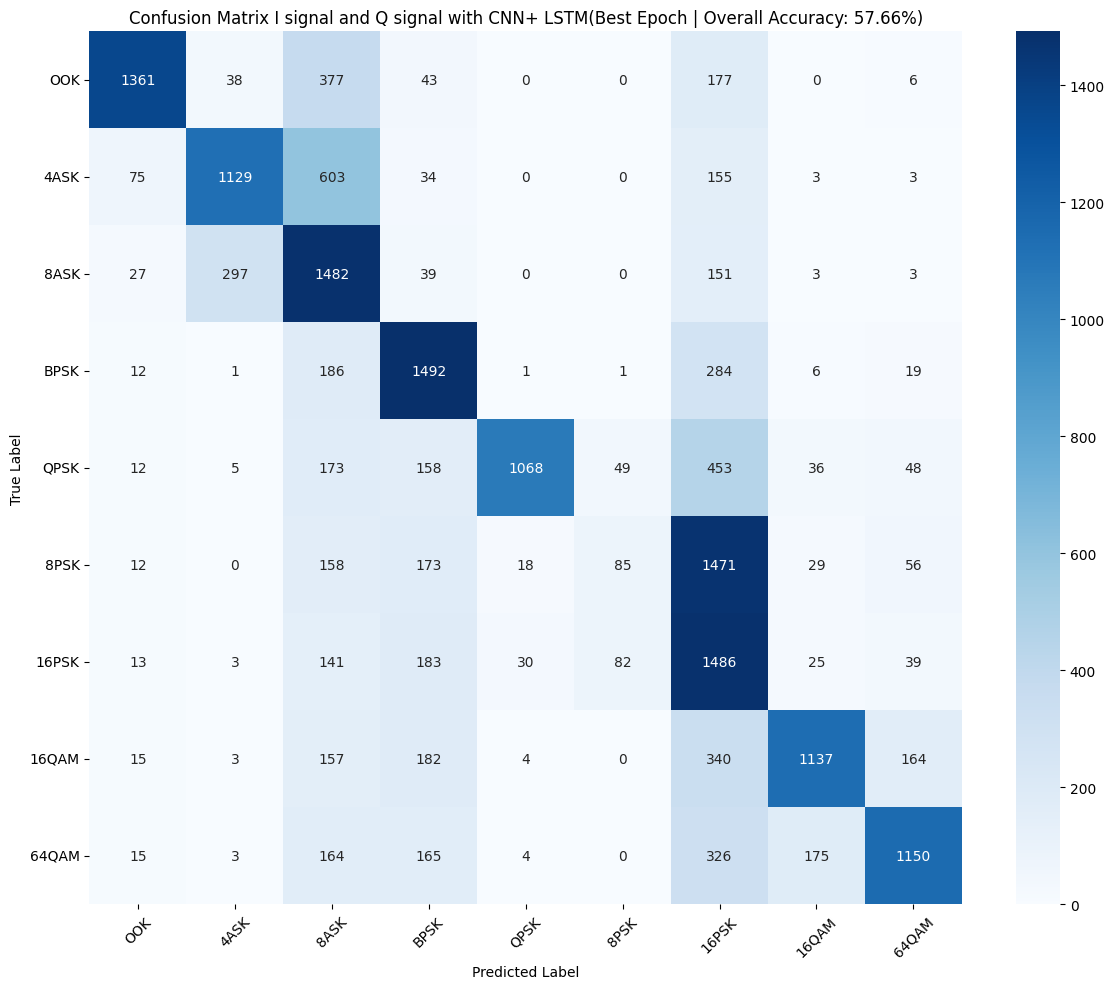

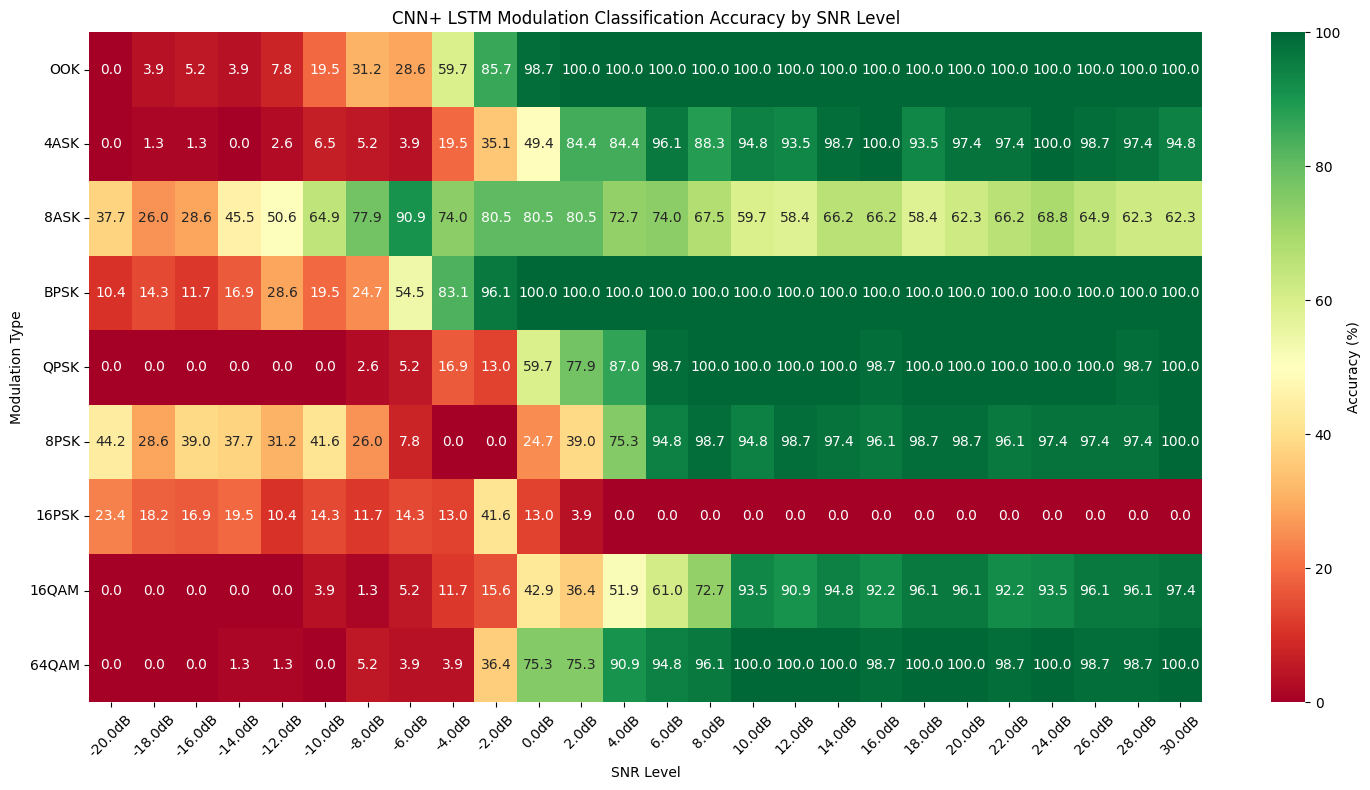

In [45]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNLSMTIQ.parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[50, 100, 125], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.6 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (60%)")
print(f"Validation dataset size: {len(valid_dataset)} (40%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_lstm_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNLSMTIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNLSMTIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNLSMTIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNLSMTIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNLSMTIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves_CNN_LSTM.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal with CNN+ LSTM(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix_CNN_LSTM.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('CNN+ LSTM Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap_CNN_LSTM.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNLSMTIQ, valid_loader, device, TARGET_MODULATIONS)

In [48]:
try:
    from CNN_LSTM_IQ_Parallel import create_parallel_CNNLSTMIQModel

    # Match the real signature: (n_labels, dropout_rate)
    model_CNNLSMTIQ_Parallel = create_parallel_CNNLSTMIQModel(n_labels=NUM_CLASSES, dropout_rate=0.3).to(device)
    print("✅ Successfully built CNNIQModel:", model_CNNLSMTIQ_Parallel)

except Exception as e:
    print(f"⚠️ Could not build CNNIQModel: {e}")

✅ Successfully built CNNIQModel: ParallelCNNLSTMIQModel(
  (i_branch): ParallelCNNLSTMBranch(
    (cnn_branch): CNNBranch(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    # --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_CNNLSMTIQ.parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[50, 100, 125], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.6 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (60%)")
print(f"Validation dataset size: {len(valid_dataset)} (40%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_lstm_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNLSMTIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNLSMTIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNLSMTIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNLSMTIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNLSMTIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves_CNN_LSTM.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal with CNN+ LSTM(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix_CNN_LSTM.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('CNN+ LSTM Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap_CNN_LSTM.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNLSMTIQ, valid_loader, device, TARGET_MODULATIONS).parameters(), 
    lr=0.0015,  # Higher initial LR
    weight_decay=5e-3,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[50, 100, 125], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.6 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (60%)")
print(f"Validation dataset size: {len(valid_dataset)} (40%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_lstm_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_CNNLSMTIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_CNNLSMTIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_CNNLSMTIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_CNNLSMTIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_CNNLSMTIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves_CNN_LSTM.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal with CNN+ LSTM(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix_CNN_LSTM.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('CNN+ LSTM Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap_CNN_LSTM.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_CNNLSMTIQ, valid_loader, device, TARGET_MODULATIONS)

In [43]:
try:
    from CNNLSTM_Attention import create_model_for_training
    model_attention_CNNLSTMIQ = create_model_for_training(n_labels=NUM_CLASSES, dropout_rate=0.3, device='cuda')
    print(f"✅ Model created with auto-selected attention heads{model_attention_CNNLSTMIQ}")
except Exception as e:
    print(f"⚠️ Could not build CNN+LSTM Attention: {e}")

✅ Model created with auto-selected attention headsCNNLSTMIQModelWithAttention(
  (i_branch): CNNLSTMBranchWithAttention(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (channel_attention): ChannelAttention(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (fc): Sequential(
        (0): Linea


Loading datasets...
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 62712 samples, 9 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset train: 62712 samples, 9 classes, 26 SNR levels
🔧 Signals will be reshaped to (32, 32) for sequence length 1024
✅ Aspect ratio: 1.00, Total elements preserved: 1024 = 1024
RadioMLIQDataset valid: 18018 samples, 9 classes, 26 SNR levels
Datasets loaded successfully.
Total dataset size: 62712
Train dataset size: 62712 (70%)
Validation dataset size: 18018 (30%)

Starting training...


Training:  89%|███████████▌ | 55/62 [00:08<00:01,  6.20it/s]
                                                            
Epochs:   0%|                                   | 1/300 [00:11<56:11, 11.28s/it]

Epoch 1/300: Train Loss: 2.4574 | Train Acc: 28.03% | Valid Loss: 1.7477 | Valid Acc: 39.92%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.21it/s]
                                                            
Epochs:   1%|▏                                  | 2/300 [00:22<55:47, 11.23s/it]

Epoch 2/300: Train Loss: 1.7930 | Train Acc: 38.74% | Valid Loss: 1.6558 | Valid Acc: 43.08%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.17it/s]
                                                            
Epochs:   1%|▎                                  | 3/300 [00:33<55:35, 11.23s/it]

Epoch 3/300: Train Loss: 1.7180 | Train Acc: 42.27% | Valid Loss: 1.6163 | Valid Acc: 46.33%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.26it/s]
                                                            
Epochs:   1%|▍                                  | 4/300 [00:44<55:17, 11.21s/it]

Epoch 4/300: Train Loss: 1.6843 | Train Acc: 43.96% | Valid Loss: 1.6072 | Valid Acc: 47.92%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.22it/s]
                                                            
Epochs:   2%|▌                                  | 5/300 [00:56<55:00, 11.19s/it]

Epoch 5/300: Train Loss: 1.6553 | Train Acc: 45.93% | Valid Loss: 1.6396 | Valid Acc: 42.64%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.21it/s]
                                                            
Epochs:   2%|▋                                  | 6/300 [01:07<54:45, 11.17s/it]

Epoch 6/300: Train Loss: 1.6296 | Train Acc: 47.32% | Valid Loss: 1.5554 | Valid Acc: 50.52%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.23it/s]
                                                            
Epochs:   2%|▊                                  | 7/300 [01:18<54:32, 11.17s/it]

Epoch 7/300: Train Loss: 1.6030 | Train Acc: 49.09% | Valid Loss: 1.5960 | Valid Acc: 45.98%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.24it/s]
                                                            
Epochs:   3%|▉                                  | 8/300 [01:29<54:17, 11.16s/it]

Epoch 8/300: Train Loss: 1.5864 | Train Acc: 49.77% | Valid Loss: 1.5217 | Valid Acc: 51.52%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.28it/s]
                                                            
Epochs:   3%|█                                  | 9/300 [01:40<54:00, 11.14s/it]

Epoch 9/300: Train Loss: 1.5729 | Train Acc: 50.61% | Valid Loss: 1.5743 | Valid Acc: 47.96%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.24it/s]
                                                            
Epochs:   3%|█▏                                | 10/300 [01:51<53:44, 11.12s/it]

Epoch 10/300: Train Loss: 1.5698 | Train Acc: 50.54% | Valid Loss: 1.5269 | Valid Acc: 50.98%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.25it/s]
                                                            
Epochs:   4%|█▏                                | 11/300 [02:02<53:33, 11.12s/it]

Epoch 11/300: Train Loss: 1.5578 | Train Acc: 51.51% | Valid Loss: 1.5188 | Valid Acc: 51.77%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.18it/s]
                                                            
Epochs:   4%|█▎                                | 12/300 [02:13<53:26, 11.13s/it]

Epoch 12/300: Train Loss: 1.5498 | Train Acc: 51.97% | Valid Loss: 1.5781 | Valid Acc: 49.03%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.24it/s]
                                                            
Epochs:   4%|█▍                                | 13/300 [02:25<53:17, 11.14s/it]

Epoch 13/300: Train Loss: 1.5385 | Train Acc: 52.48% | Valid Loss: 1.5177 | Valid Acc: 52.63%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.11it/s]
                                                            
Epochs:   5%|█▌                                | 14/300 [02:36<53:16, 11.18s/it]

Epoch 14/300: Train Loss: 1.5359 | Train Acc: 52.68% | Valid Loss: 1.5158 | Valid Acc: 51.79%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.23it/s]
                                                            
Epochs:   5%|█▋                                | 15/300 [02:47<53:01, 11.16s/it]

Epoch 15/300: Train Loss: 1.5298 | Train Acc: 53.02% | Valid Loss: 1.4920 | Valid Acc: 53.62%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.20it/s]
                                                            
Epochs:   5%|█▊                                | 16/300 [02:58<52:48, 11.16s/it]

Epoch 16/300: Train Loss: 1.5208 | Train Acc: 53.40% | Valid Loss: 1.5670 | Valid Acc: 50.02%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.10it/s]
                                                            
Epochs:   6%|█▉                                | 17/300 [03:09<52:46, 11.19s/it]

Epoch 17/300: Train Loss: 1.5173 | Train Acc: 53.73% | Valid Loss: 1.5750 | Valid Acc: 49.94%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.20it/s]
                                                            
Epochs:   6%|██                                | 18/300 [03:21<52:30, 11.17s/it]

Epoch 18/300: Train Loss: 1.5107 | Train Acc: 54.12% | Valid Loss: 1.4875 | Valid Acc: 54.63%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.18it/s]
                                                            
Epochs:   6%|██▏                               | 19/300 [03:32<52:15, 11.16s/it]

Epoch 19/300: Train Loss: 1.5106 | Train Acc: 54.01% | Valid Loss: 1.4934 | Valid Acc: 53.88%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.21it/s]
                                                            
Epochs:   7%|██▎                               | 20/300 [03:43<52:03, 11.16s/it]

Epoch 20/300: Train Loss: 1.5060 | Train Acc: 54.72% | Valid Loss: 1.4911 | Valid Acc: 54.40%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.26it/s]
                                                            
Epochs:   7%|██▍                               | 21/300 [03:54<51:46, 11.13s/it]

Epoch 21/300: Train Loss: 1.5016 | Train Acc: 54.81% | Valid Loss: 1.4903 | Valid Acc: 54.76%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.28it/s]
                                                            
Epochs:   7%|██▍                               | 22/300 [04:05<51:30, 11.12s/it]

Epoch 22/300: Train Loss: 1.4975 | Train Acc: 55.19% | Valid Loss: 1.4937 | Valid Acc: 53.59%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.20it/s]
                                                            
Epochs:   8%|██▌                               | 23/300 [04:16<51:22, 11.13s/it]

Epoch 23/300: Train Loss: 1.4877 | Train Acc: 55.99% | Valid Loss: 1.4554 | Valid Acc: 57.17%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.23it/s]
                                                            
Epochs:   8%|██▋                               | 24/300 [04:27<51:12, 11.13s/it]

Epoch 24/300: Train Loss: 1.4856 | Train Acc: 56.05% | Valid Loss: 1.4508 | Valid Acc: 56.88%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.27it/s]
                                                            
Epochs:   8%|██▊                               | 25/300 [04:38<50:57, 11.12s/it]

Epoch 25/300: Train Loss: 1.4800 | Train Acc: 56.39% | Valid Loss: 1.5200 | Valid Acc: 53.56%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.20it/s]
                                                            
Epochs:   9%|██▉                               | 26/300 [04:49<50:50, 11.13s/it]

Epoch 26/300: Train Loss: 1.4748 | Train Acc: 56.91% | Valid Loss: 1.4635 | Valid Acc: 55.97%



Training:  97%|████████████▌| 60/62 [00:09<00:00,  5.97it/s]
                                                            
Epochs:   9%|███                               | 27/300 [05:01<51:09, 11.24s/it]

Epoch 27/300: Train Loss: 1.4694 | Train Acc: 57.23% | Valid Loss: 1.4693 | Valid Acc: 55.66%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.21it/s]
                                                            
Epochs:   9%|███▏                              | 28/300 [05:12<50:56, 11.24s/it]

Epoch 28/300: Train Loss: 1.4696 | Train Acc: 57.15% | Valid Loss: 1.4442 | Valid Acc: 57.92%



Training: 100%|█████████████| 62/62 [00:10<00:00,  6.19it/s]
                                                            
Epochs:  10%|███▎                              | 29/300 [05:24<51:13, 11.34s/it]

Epoch 29/300: Train Loss: 1.4612 | Train Acc: 57.69% | Valid Loss: 1.4421 | Valid Acc: 57.45%



Training:  90%|███████████▋ | 56/62 [00:09<00:01,  5.99it/s]
                                                            
Epochs:  10%|███▍                              | 30/300 [05:35<51:15, 11.39s/it]

Epoch 30/300: Train Loss: 1.4549 | Train Acc: 57.87% | Valid Loss: 1.5868 | Valid Acc: 49.92%



Training:  92%|███████████▉ | 57/62 [00:09<00:00,  5.85it/s]
                                                            
Epochs:  10%|███▌                              | 31/300 [05:47<51:38, 11.52s/it]

Epoch 31/300: Train Loss: 1.4538 | Train Acc: 58.05% | Valid Loss: 1.4770 | Valid Acc: 56.13%



Training:  95%|████████████▎| 59/62 [00:09<00:00,  6.04it/s]
                                                            
Epochs:  11%|███▋                              | 32/300 [05:59<51:33, 11.54s/it]

Epoch 32/300: Train Loss: 1.4521 | Train Acc: 58.27% | Valid Loss: 1.4415 | Valid Acc: 57.67%



Training:  95%|████████████▎| 59/62 [00:09<00:00,  5.91it/s]
                                                            
Epochs:  11%|███▋                              | 33/300 [06:10<51:32, 11.58s/it]

Epoch 33/300: Train Loss: 1.4442 | Train Acc: 58.34% | Valid Loss: 1.5056 | Valid Acc: 53.52%



Training:  98%|████████████▊| 61/62 [00:10<00:00,  5.83it/s]
                                                            
Epochs:  11%|███▊                              | 34/300 [06:22<51:42, 11.66s/it]

Epoch 34/300: Train Loss: 1.4462 | Train Acc: 58.44% | Valid Loss: 1.4316 | Valid Acc: 58.95%



Training:  89%|███████████▌ | 55/62 [00:08<00:01,  6.25it/s]
                                                            
Epochs:  12%|███▉                              | 35/300 [06:33<50:55, 11.53s/it]

Epoch 35/300: Train Loss: 1.4424 | Train Acc: 58.55% | Valid Loss: 1.4486 | Valid Acc: 56.33%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.29it/s]
                                                            
Epochs:  12%|████                              | 36/300 [06:45<50:09, 11.40s/it]

Epoch 36/300: Train Loss: 1.4406 | Train Acc: 58.51% | Valid Loss: 1.5175 | Valid Acc: 54.09%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.30it/s]
                                                            
Epochs:  12%|████▏                             | 37/300 [06:56<49:36, 11.32s/it]

Epoch 37/300: Train Loss: 1.4362 | Train Acc: 59.06% | Valid Loss: 1.4624 | Valid Acc: 56.23%



Training:  98%|████████████▊| 61/62 [00:09<00:00,  6.29it/s]
                                                            
Epochs:  13%|████▎                             | 38/300 [07:07<49:16, 11.28s/it]

Epoch 38/300: Train Loss: 1.4342 | Train Acc: 59.03% | Valid Loss: 1.4658 | Valid Acc: 56.19%



Training:  90%|███████████▋ | 56/62 [00:09<00:00,  6.26it/s]
                                                            
Epochs:  13%|████▍                             | 39/300 [07:18<48:55, 11.25s/it]

Epoch 39/300: Train Loss: 1.4316 | Train Acc: 59.50% | Valid Loss: 1.4723 | Valid Acc: 56.53%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.25it/s]
                                                            
Epochs:  13%|████▌                             | 40/300 [07:29<48:30, 11.20s/it]

Epoch 40/300: Train Loss: 1.4306 | Train Acc: 59.27% | Valid Loss: 1.5462 | Valid Acc: 53.27%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.27it/s]
                                                            
Epochs:  14%|████▋                             | 41/300 [07:40<48:08, 11.15s/it]

Epoch 41/300: Train Loss: 1.4284 | Train Acc: 59.37% | Valid Loss: 1.4420 | Valid Acc: 57.96%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.25it/s]
                                                            
Epochs:  14%|████▊                             | 42/300 [07:51<47:49, 11.12s/it]

Epoch 42/300: Train Loss: 1.4228 | Train Acc: 59.47% | Valid Loss: 1.4336 | Valid Acc: 57.99%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.27it/s]
                                                            
Epochs:  14%|████▊                             | 43/300 [08:02<47:31, 11.09s/it]

Epoch 43/300: Train Loss: 1.4264 | Train Acc: 59.69% | Valid Loss: 1.4746 | Valid Acc: 56.40%



Training:  90%|███████████▋ | 56/62 [00:08<00:00,  6.22it/s]
                                                            
Epochs:  14%|████▊                             | 43/300 [08:13<49:11, 11.49s/it]

Early stopping at epoch 44

Training complete.
Best validation accuracy: 58.95%


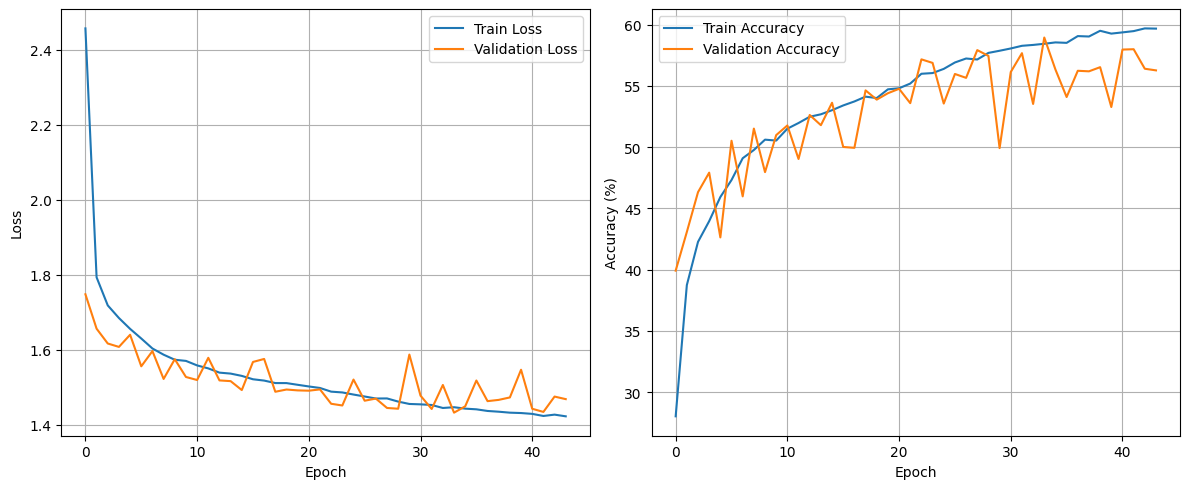

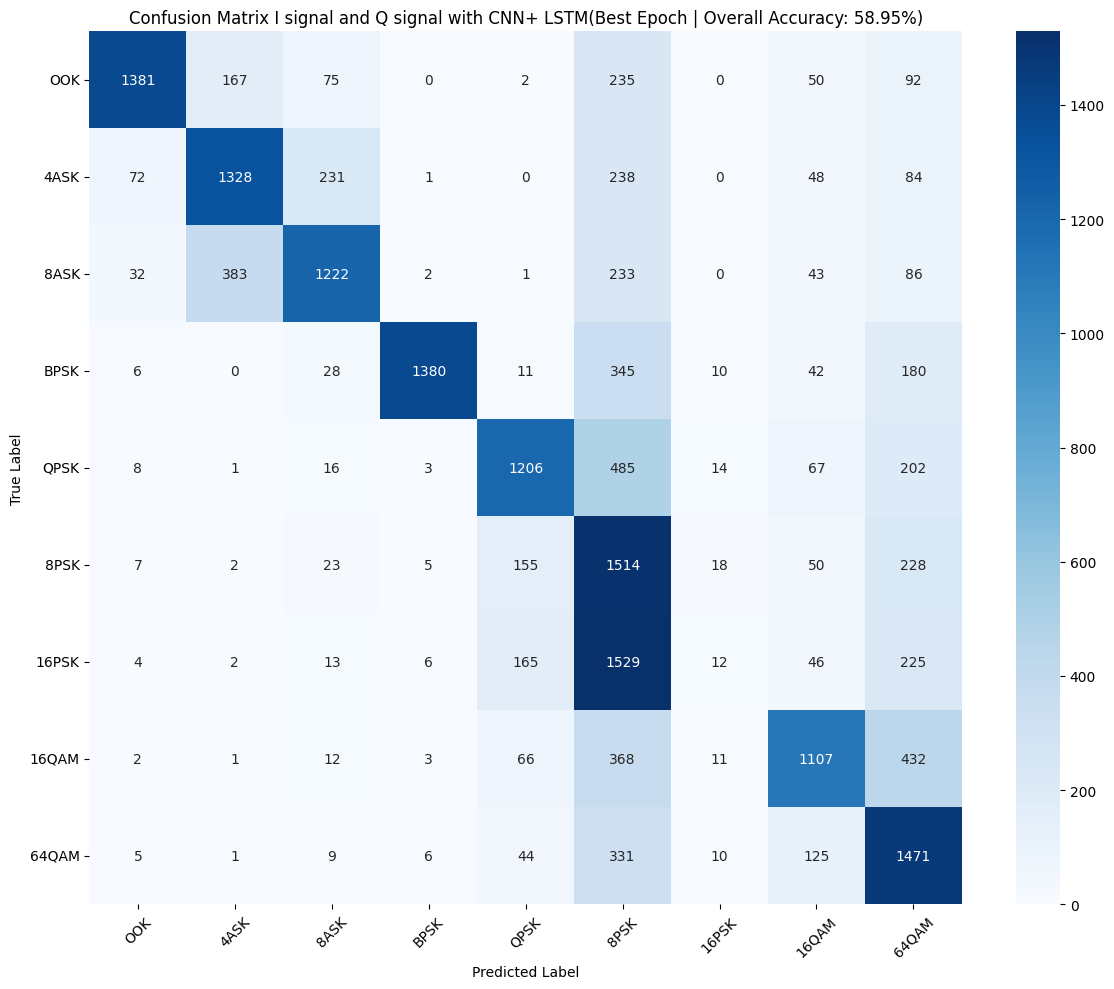

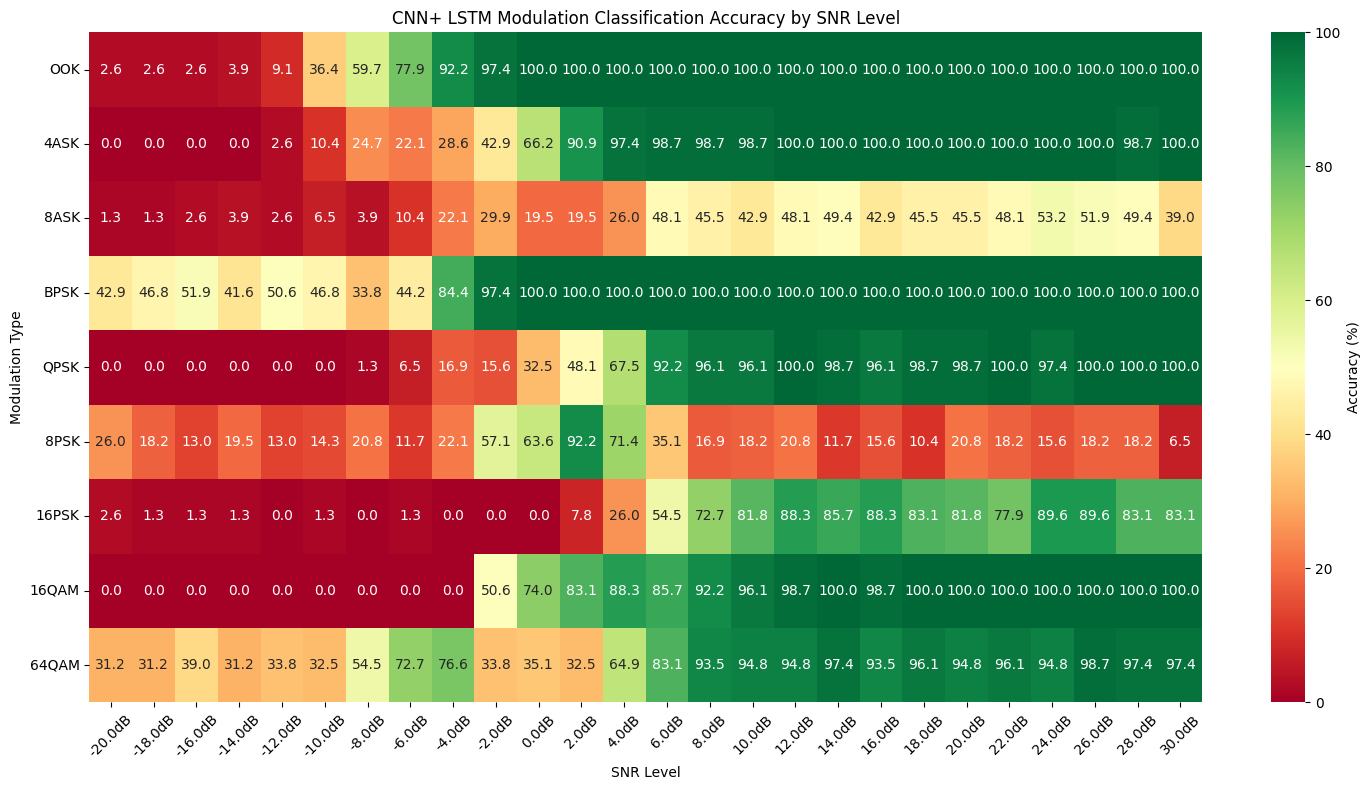

In [44]:
# --- Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)  # Add label smoothing to reduce overfitting

optimizer = optim.AdamW(
    model_attention_CNNLSTMIQ.parameters(), 
    lr=0.002,  # Higher initial LR
    weight_decay=5e-4,
    betas=(0.9, 0.999)
)

# Step scheduler
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[75, 125, 150], 
    gamma=0.5
)

scaler = GradScaler()

# --- Data Loaders ---
print("\nLoading datasets...")
# Load full dataset and split 80% train, 20% validation
full_dataset = RadioMLIQDataset('train', use_fft=False)  # Assuming this loads the full dataset
dataset_size = len(full_dataset)
train_size = int(0.75 * dataset_size)
valid_size = dataset_size - train_size

# Split dataset randomly
train_dataset = RadioMLIQDataset('train', use_fft=False)
valid_dataset = RadioMLIQDataset('valid', use_fft=False)  # Use separate valid split

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True,
    num_workers=0,          # FIXED: Set to 0 for HDF5 compatibility
    persistent_workers=False # FIXED: Must be False when num_workers=0
)
print("Datasets loaded successfully.")
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {len(train_dataset)} (70%)")
print(f"Validation dataset size: {len(valid_dataset)} (30%)")

# --- Training and Validation Loop ---
train_losses = []
valid_losses = []
train_accuracies = []  # Store training accuracies
valid_accuracies = []
best_accuracy = 0.0
patience_counter = 0
patience = 10
BEST_MODEL_PATH = 'best_cnn_lstm__attention_model_IQ.pth'

# Store final predictions/labels for confusion matrix
final_predictions = []
final_true_labels = []

print("\nStarting training...")
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs", ncols=80):
    model_attention_CNNLSTMIQ.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Cleaner progress bar - updates less frequently, no loss display per batch
    for i_inputs, q_inputs, labels, _ in tqdm(train_loader, desc=f"Training", leave=False, ncols=60, mininterval=1.0):
        i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model_attention_CNNLSTMIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * i_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # --- Validation Phase ---
    model_attention_CNNLSTMIQ.eval()
    validation_loss = 0.0
    correct_valid = 0
    total_valid = 0
    epoch_predictions = []
    epoch_true_labels = []

    with torch.no_grad():
        for i_inputs, q_inputs, labels, _ in tqdm(valid_loader, desc=f"Validation", leave=False, ncols=60, mininterval=1.0):
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)

            outputs = model_attention_CNNLSTMIQ(i_inputs, q_inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * i_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
            
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())

    epoch_valid_loss = validation_loss / len(valid_dataset)
    epoch_valid_accuracy = 100. * correct_valid / total_valid
    valid_losses.append(epoch_valid_loss)
    valid_accuracies.append(epoch_valid_accuracy)
    
    scheduler.step(epoch_valid_accuracy)
    
    # Check for best accuracy and save model
    if epoch_valid_accuracy > best_accuracy:
        best_accuracy = epoch_valid_accuracy
        patience_counter = 0
        final_predictions = epoch_predictions
        final_true_labels = epoch_true_labels
        torch.save(model_attention_CNNLSTMIQ.state_dict(), BEST_MODEL_PATH)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Valid Loss: {epoch_valid_loss:.4f} | "
          f"Valid Acc: {epoch_valid_accuracy:.2f}%")

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.2f}%")

# --- Plot Training Curves ---
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves_CNN_LSTM_Attention.png')
plt.show()

# --- Confusion Matrix for Best Epoch (Run in separate cell) ---
# Generate confusion matrix
cm = confusion_matrix(final_true_labels, final_predictions)
accuracy = 100. * np.diag(cm).sum() / cm.sum()

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_MODULATIONS, 
            yticklabels=TARGET_MODULATIONS)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix I signal and Q signal with CNN+ LSTM(Best Epoch | Overall Accuracy: {accuracy:.2f}%)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('best_confusion_matrix_CNN_LSTM_Attention.png')
plt.show()

# --- Per-Modulation Accuracy Heatmap ---
def plot_modulation_snr_accuracy_heatmap(model, dataloader, device, target_modulations):
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []
    
    with torch.no_grad():
        for i_inputs, q_inputs, labels, snrs in dataloader:
            i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(i_inputs, q_inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.numpy())
    
    predictions_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    unique_snrs = sorted(predictions_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))
    
    for i, mod in enumerate(target_modulations):
        for j, snr in enumerate(unique_snrs):
            subset = predictions_df[(predictions_df['true_label'] == i) & (predictions_df['snr'] == snr)]
            if len(subset) > 0:
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(accuracy_matrix, 
                xticklabels=[f'{snr}dB' for snr in unique_snrs],
                yticklabels=target_modulations,
                annot=True, 
                fmt='.1f', 
                cmap='RdYlGn',
                vmin=0, 
                vmax=100,
                cbar_kws={'label': 'Accuracy (%)'})
    
    plt.title('CNN+ LSTM Modulation Classification Accuracy by SNR Level')
    plt.xlabel('SNR Level')
    plt.ylabel('Modulation Type')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('modulation_snr_accuracy_heatmap_CNN_LSTM_Attention.png')
    plt.show()

plot_modulation_snr_accuracy_heatmap(model_attention_CNNLSTMIQ,valid_loader, device, TARGET_MODULATIONS)